In [6]:
library(tidyverse)
library(tidymodels)

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [19]:
con_names1<-c("age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang",
                                                 "oldpeak","slope","ca","thal","num")
heart_cleaveland<-read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",col_names = con_names1)
heart_cleaveland_1<-filter(heart_cleaveland, num == 1 | num == 0)
heart_cleaveland_1


Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
56,1,2,120,236,0,0,178,0,0.8,1,0.0,3.0,0
57,0,4,120,354,0,0,163,1,0.6,1,0.0,3.0,0
53,1,4,140,203,1,2,155,1,3.1,3,0.0,7.0,1
57,1,4,140,192,0,0,148,0,0.4,2,0.0,6.0,0
56,0,2,140,294,0,2,153,0,1.3,2,0.0,3.0,0


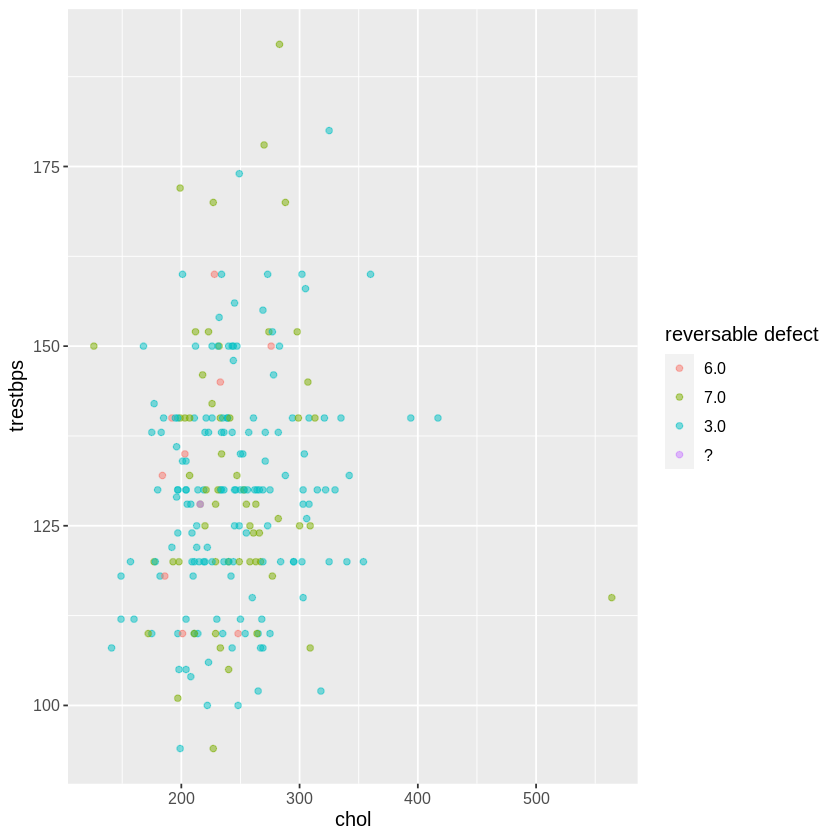

In [28]:
set.seed(1)
cleaveland_mutate<-heart_cleaveland_1|>
mutate(sex=as_factor(sex))|>
mutate(cp=as_factor(cp))|>
mutate(fbs=as_factor(fbs))|>
mutate(restecg=as_factor(restecg))|>
mutate(exang=as_factor(exang))|>
mutate(slope=as_factor(slope))|>
mutate(ca=as_factor(ca))|>
mutate(thal=as_factor(thal))|>
mutate(num=as_factor(num))



cleaveland_plot1 <- cleaveland_mutate |>
  ggplot(aes(x = chol, y = trestbps, color = thal)) +
  geom_point(alpha = 0.5) +
  labs(color = "reversable defect") + 
  theme(text = element_text(size = 12))

cleaveland_plot1
    

In [3]:
read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names = con_names1)

Rows: 123 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, chol, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
32,1,1,95,0,?,0,127,0,.7,1,?,?,1
34,1,4,115,0,?,?,154,0,.2,1,?,?,1
35,1,4,?,0,?,0,130,1,?,?,?,7,3
36,1,4,110,0,?,0,125,1,1,2,?,6,1
38,0,4,105,0,?,0,166,0,2.8,1,?,?,2
38,0,4,110,0,0,0,156,0,0,2,?,3,1
38,1,3,100,0,?,0,179,0,-1.1,1,?,?,0
38,1,3,115,0,0,0,128,1,0,2,?,7,1
38,1,4,135,0,?,0,150,0,0,?,?,3,2


In [4]:
read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names = con_names1)


Rows: 200 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): trestbps, chol, fbs, thalach, exang, oldpeak, slope, ca, thal
dbl (5): age, sex, cp, restecg, num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
63,1,4,140,260,0,1,112,1,3,2,?,?,2
44,1,4,130,209,0,1,127,0,0,?,?,?,0
60,1,4,132,218,0,1,140,1,1.5,3,?,?,2
55,1,4,142,228,0,1,149,1,2.5,1,?,?,1
66,1,3,110,213,1,2,99,1,1.3,2,?,?,0
66,1,3,120,0,0,1,120,0,-0.5,1,?,?,0
65,1,4,150,236,1,1,105,1,0,?,?,?,3
60,1,3,180,0,0,1,140,1,1.5,2,?,?,0
60,1,3,120,0,?,0,141,1,2,1,?,?,3


In [5]:
read_delim("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data",delim=" ", col_names = con_names1)

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: " "
dbl (14): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
40,1,2,140,289,0,0,172,0,0.0,-9,-9,-9,0
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,1
37,1,2,130,283,0,1,98,0,0.0,-9,-9,-9,0
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,3
54,1,3,150,-9,0,0,122,0,0.0,-9,-9,-9,0
39,1,3,120,339,0,0,170,0,0.0,-9,-9,-9,0
45,0,2,130,237,0,0,170,0,0.0,-9,-9,-9,0
54,1,2,110,208,0,0,142,0,0.0,-9,-9,-9,0
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,1
